*The main gola of this project is to predict he sale price of a house using various features such as neighborhood, area, year built, garage type, and more from a given dataset. Thi project is based on rgression analysis usiing advanced machine learnign techniques.*

*I imported essential python libraries like pandas, numpy, matplotlib, seaborn, and various modules from sklearn for data analysis, visualization, preprocessign, model building, and evaluation.*

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.impute import SimpleImputer
import warnings 
warnings.filterwarnings("ignore")
import joblib

*I worte a function to load both training and testing datasets using pandas.read_csv(). This modular approach helps me keep the code clean and reusable.*

In [20]:
def load_data():
    train =pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    return train,test

*I created a Bar plot to visualize missing data. This helped me identify which columns had significant missing values and required cleaning or removal*

In [21]:
def vilusalize_missing_value(data,title="Missing Value"):
    missing =data.isna().sum()
    missing = missing[missing>0]
    plt.figure(figsize=(12,6))
    missing.plot(kind ="bar",color ="tomato")
    plt.title(title)
    plt.ylabel("Number of missing value")
    plt.xticks(rotation =45)
    plt.tight_layout()
    plt.show()

*I deoped irrelevant columns wiht too many missing values. I filled missing numerical columns with the median. For categorical columns, I used the mode to fill missing values.*

In [22]:
def preprocess_data(df,is_train=True):
    drop_cols =["Alley","MasVnrType","FireplaceQu","PoolQC","Fence","MiscFeature"]
    if not is_train:
        drop_cols = ["PoolQC","MiscFeature","Alley","Fence","MasVnrType","FireplaceQu","LotFrontage"]
    df.drop(columns =drop_cols,inplace =True,errors="ignore")
    number_col =df.select_dtypes(include ="number").columns
    for col in number_col:
        df[col].fillna(df[col].median(),inplace =True)
    object_col = df.select_dtypes(include ="object").columns
    for col in object_col:
        if df[col] .isna().sum()>0:
            mode_val =df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col].fillna(mode_val,inplace = True)
    return df


*Combined train and test for consistent encoding. I a applied Label Encoding to convert all object-type columns inot numeric values using LabelEncoder. Most ML algorithm can't handle string values directly. Encodign makes the data usablle for model training.*

In [23]:
def encode_data(train,test):
    combine =pd.concat([train,test],axis=0).reset_index(drop=True)
    label_encoder ={}
    for col in combine.select_dtypes(include="object").columns:
        le =LabelEncoder()
        combine[col] = le.fit_transform(combine[col].astype(str))
        label_encoder[col] = le
    train_encoder =combine.iloc[: len(train),:]
    test_encoder =combine.iloc[len(train):,:].reset_index(drop=True)


    imputer = SimpleImputer(strategy="median")
    train_encoder = pd.DataFrame(imputer.fit_transform(train_encoder), columns=train_encoder.columns)
    test_encoder = pd.DataFrame(imputer.transform(test_encoder), columns=test_encoder.columns)
    return train_encoder,test_encoder,label_encoder



*I used StandardScaler to scale numerical features so that they all have a similar range. This help models like SVM, Linear Regression,and KNN to perform better, as they are sensitive to feature scales.*

In [24]:
def scale_data(train,test,target_columns):
    scalear =StandardScaler()
    x = train.drop(columns =[target_columns])
    y = train[target_columns]
    x_scaler =scalear.fit_transform(x)
    test_scaler =scalear.transform(test)
    return x_scaler,y,test_scaler,scalear

*Trying different models allows me to compare their performance and select the best one based on evaluation metrics.*

In [25]:
def get_models():
    return{
        "RandomForestRegressor":RandomForestRegressor(),
        "DecisionTreeRegressor":DecisionTreeRegressor(),
        "KNeighborsRegressor":KNeighborsRegressor(),
        "Ridge":Ridge(),
        "Lasso":Lasso(),
        "SVR":SVR(),
        "LinearRegression":LinearRegression(),
        "GradientBoostingRegressor":GradientBoostingRegressor()

    }


*I created a parameter grid for each model and used GridSearchCV to find the best parameters. Tuning helps improve model performance by finding optimal values fro each model's settings.*

In [26]:
def get_param_grids():
    return {
        "RandomForestRegressor": {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]},
        "GradientBoostingRegressor": {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]},
        "SVR": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        "DecisionTreeRegressor": {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
        "LinearRegression": {},
        "XGBRegressor": {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]},
        "Ridge": {'alpha': [0.1, 1.0, 10.0]},
        "Lasso": {'alpha': [0.1, 1.0, 10.0]},
        "KNeighborsRegressor": {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    }

*This function plots a scatter plot comparing actual and predicted house prices. Point are colore based on absoluted prediction error and sized by actual prices. A diagonal line shows perfect predicton, helping us visualize model accuracy.*

In [27]:
def actual_vs_predictied(y_true,y_pred):
    errors =np.abs(y_true,y_pred)
    plt.figure(figsize=(10,7))
    sns.scatterplot(x=y_true,y=y_pred,hue=errors,palette="coolwarm",legend=True,size=y_true,sizes=(30,150))
    plt.plot([y_true.min(),y_true.max()],[y_true.min(),y_true.max()],label='Perfect Prediction')
    plt.title("Actual Price vs Predicted prices")
    plt.xlabel("Acutal Sales Prices")
    plt.ylabel("Predicted sales Prices")
    plt.legend()
    plt.tight_layout()

*This function trains multiple regression models and evaluates them using cross-validation and r2 score. It performs hyperparameter tuning wiht GridSearchCV if a parameter grid is avaliable. The best performing model is select based on validation r2 score. Performance metrics like MAE and MSE are printed, and predictions are visualized. Finally the best model is saved using joblib for future use.*

In [28]:
def train_and_evaluate_models(x_train, y_train, x_valid, y_valid):
    models = get_models()
    param_grids = get_param_grids()
    best_model = None
    best_score = -np.inf
    best_name = ""
    best_preds = None

    for name, model in models.items():
        print(f"Training {name}...")
        param_grid = param_grids.get(name, {})
        if param_grid:
            grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
            grid.fit(x_train, y_train)
            model = grid.best_estimator_
            print(f"Best params for {name}: {grid.best_params_}")
        else:
            model.fit(x_train, y_train)
        cross_validation =cross_val_score(model,x_train,y_train,cv=5,scoring="r2")
        preds = model.predict(x_valid)
        r2 = r2_score(y_valid, preds)
        men_ab =mean_absolute_error(y_valid,preds)
        men_sq =mean_squared_error(y_valid,preds)
        print(f"{name} R2 Score: {r2:.4f}")
        print(f"mean_absolute_error:{men_ab}")
        print(f"mean_squared_error:{men_sq}")


        if r2 > best_score:
            best_model = model
            best_score = r2
            best_name = name
            best_preds = preds


    print(f"Best Model: {best_name} with R2 Score: {best_score:.4f}")
    actual_vs_predictied(y_valid,best_preds)

    model_filename = f"best_model_{best_name}.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Best model saved as {model_filename}")
    return best_model,cross_validation

*This function runs the complete pipline for the house price prediction project. It starts by loading the train and test datasets, visualize missing values, and preprocessing the data separately. Then it encodes ctergorical features, scales the data, and splits the training set for validation. Multiple models are trained and evaluated to select the best one based on r2 score. Finally the best model is retrained on the full data and used to make predictions on the test set.*

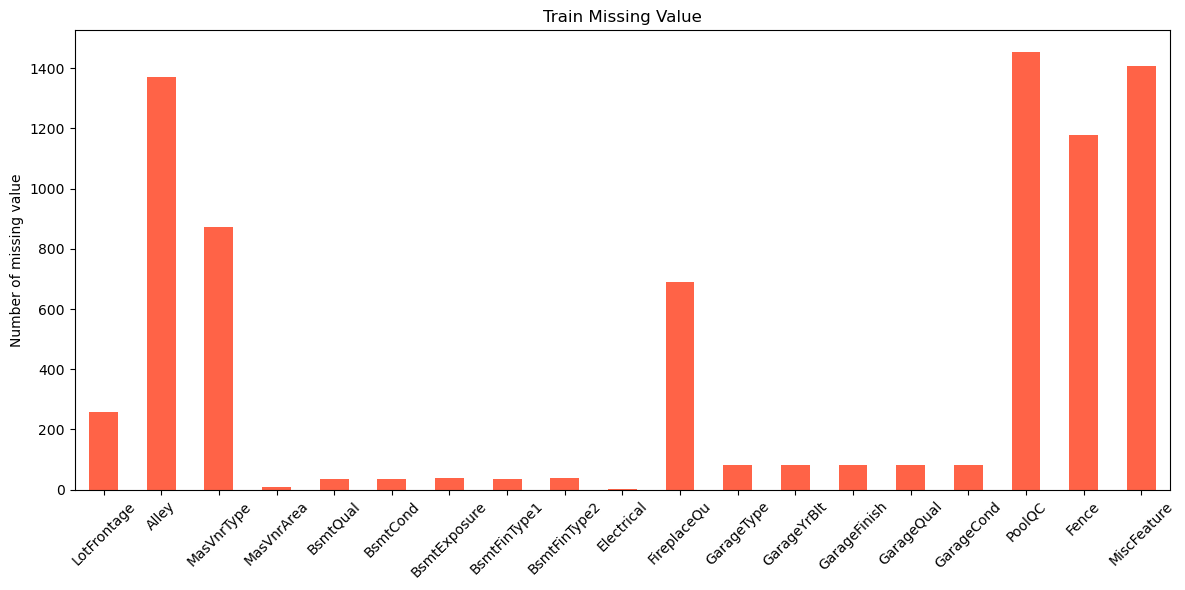

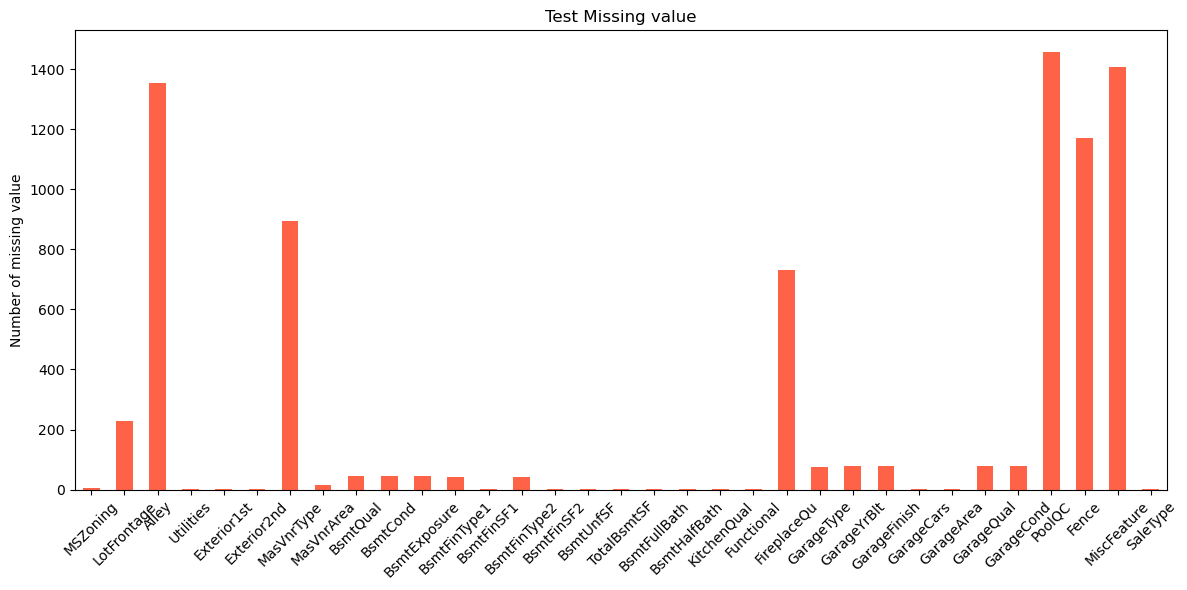

Training RandomForestRegressor...
Best params for RandomForestRegressor: {'max_depth': 20, 'n_estimators': 100}
RandomForestRegressor R2 Score: 0.8901
mean_absolute_error:17698.13947968328
mean_squared_error:842827605.4117154
Training DecisionTreeRegressor...
Best params for DecisionTreeRegressor: {'max_depth': None, 'min_samples_split': 5}
DecisionTreeRegressor R2 Score: 0.7946
mean_absolute_error:27139.03852739726
mean_squared_error:1575414637.6903777
Training KNeighborsRegressor...
Best params for KNeighborsRegressor: {'n_neighbors': 7, 'weights': 'distance'}
KNeighborsRegressor R2 Score: 0.7936
mean_absolute_error:23174.243719659724
mean_squared_error:1582977058.5830152
Training Ridge...
Best params for Ridge: {'alpha': 10.0}
Ridge R2 Score: 0.8454
mean_absolute_error:21407.704373691013
mean_squared_error:1185556733.2166116
Training Lasso...
Best params for Lasso: {'alpha': 10.0}
Lasso R2 Score: 0.8451
mean_absolute_error:21475.345179688837
mean_squared_error:1187908150.3207748
Tra

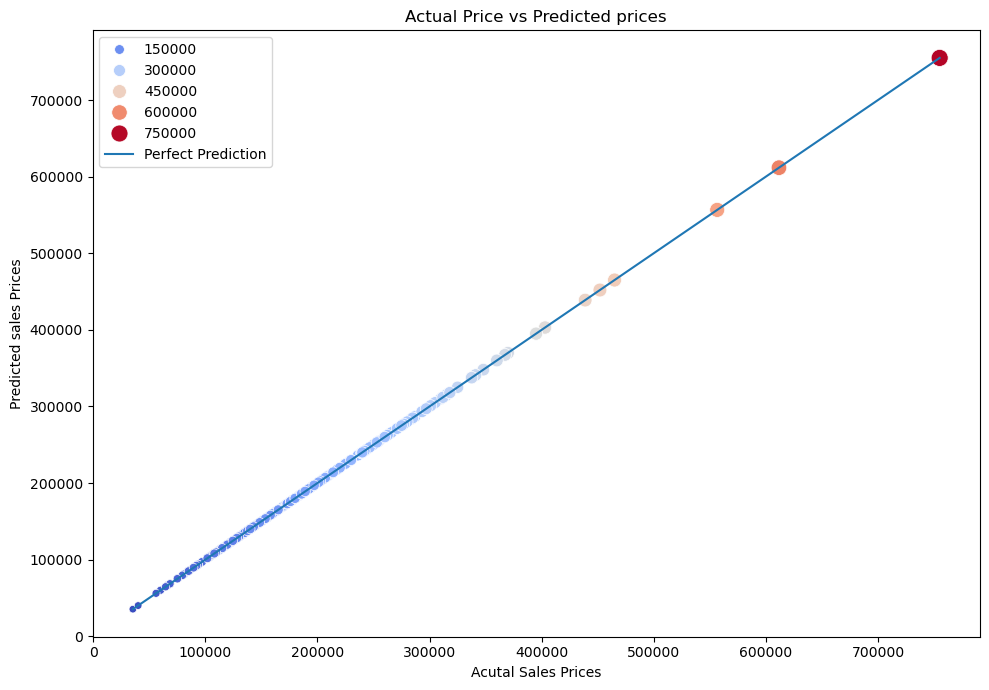

In [29]:
def run_pipeline():
    train, test = load_data()
    vilusalize_missing_value(train, title="Train Missing Value")
    vilusalize_missing_value(test, title="Test Missing value")

    # Preprocess train and test separately
    train = preprocess_data(train, is_train=True)
    test = preprocess_data(test, is_train=False)

    # Save target column separately
    target = train["SalePrice"]

    # Encode categorical features on combined dataset
    train_encoder, test_encoder, _ = encode_data(train.drop(columns=["SalePrice"]), test)

    # Add target column back only to train_encoder (not test)
    train_encoder["SalePrice"] = target

    # Scale features (excluding target)
    x_scaled, y, test_scaled, scaler = scale_data(train_encoder, test_encoder, target_columns="SalePrice")

    # Split train data for validation
    x_train, x_valid, y_train, y_valid = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

    # Train and evaluate models
    best_model,cross_validation = train_and_evaluate_models(x_train, y_train, x_valid, y_valid)

    # Final training on full train data
    best_model.fit(x_scaled, y)

    # Predict on test data
    predictions = best_model.predict(test_scaled)


if __name__ == "__main__":
    run_pipeline()


In [31]:
loaded_model =joblib.load("best_model_GradientBoostingRegressor.joblib")
loaded_model

GradientBoostingRegressor()